In [1]:
import concurrent.futures
import copy
import datetime
import hashlib
import json
import logging
import numpy as np
import os
import pandas as pd
import random
import re
import yaml
from concurrent.futures import ThreadPoolExecutor, as_completed
from copy import deepcopy
from pathlib import Path
from PIL import Image, ImageOps
from tqdm import tqdm
import shutil
import traceback
import threading
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

class DatasetChecker:
    def __init__(self, config_path: str, num_workers: int = 8, verbose: bool = True):
        """
        Initialize dataset checker with a configuration file and thread settings.
        """

        self.config_path = Path(config_path)
        if not self.config_path.exists():
            raise FileNotFoundError(f"Config file not found: {self.config_path}")

        # Load raw configuration
        cfg = self._load_config(config_path)
        self.root_dir = Path(config_path).resolve().parents[0]

        # Prepare output directories
        self.output_dir = (self.root_dir / cfg.get("output_dir", "quality_output")).resolve()
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.examples_dir = self.output_dir / "examples"
        self.examples_dir.mkdir(parents=True, exist_ok=True)
        self.density_dir = self.output_dir / "density_maps"
        self.density_dir.mkdir(parents=True, exist_ok=True)

        # Configure logging
        log_file = self.output_dir / "quality_check.log"
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s - %(levelname)s - %(message)s",
            handlers=[
                logging.FileHandler(log_file, mode="w"),
                logging.StreamHandler() if verbose else logging.NullHandler(),
            ],
        )
        self.logger = logging.getLogger("DatasetChecker")

        # Validate configuration
        self.config = self._validate_config(cfg)

        # Reproducibility
        seed = self.config.get("seed", 42)
        random.seed(seed)
        np.random.seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)

        # Thread settings
        self.num_workers = self.config.get("num_workers", num_workers)

        # Initialize image directories and class mappings
        self.image_dirs = {
            split: (self.root_dir / path).resolve()
            for split, path in self.config.get("image_dirs", {}).items()
        }
        self.class2id = {cls: i + 1 for i, cls in enumerate(self.config.get("classes", []))}
        self.id2class = {v: k for k, v in self.class2id.items()}

        # Initialize caches and history
        self._init_cache_and_history()

        # Initialize core containers
        self.annotations_by_split = {}
        self.filename_map = {}
        self.history = []
        self.metadata = {
            "version": "2.0",
            "started_at": datetime.datetime.now().isoformat(),
            "config_file": str(self.config_path.resolve()),
        }

        self.logger.info(f"DatasetChecker initialized successfully.")
        self.logger.info(f"Output directory: {self.output_dir}")
        self.logger.info(f"Splits found: {list(self.image_dirs.keys())}")
        self.logger.info(f"Classes: {list(self.class2id.keys())}")
        
    def _load_config(self, path: str):
        """
        Load dataset configuration file (YAML or JSON).
        """
        path = Path(path)
        if not path.exists():
            raise FileNotFoundError(f"Config file not found: {path}")

        if path.suffix in [".yaml", ".yml"]:
            with open(path, "r", encoding="utf-8") as f:
                return yaml.safe_load(f)
        elif path.suffix == ".json":
            with open(path, "r", encoding="utf-8") as f:
                return json.load(f)
        else:
            raise ValueError(f"Unsupported config format: {path.suffix}")

    def _validate_config(self, cfg: dict):
        """
        Validate and normalize the configuration dictionary for DatasetQualityCheckerV2.
        """

        required_fields = ["splits", "image_dirs", "classes", "annotations", "verify"]
        for key in required_fields:
            if key not in cfg:
                raise ValueError(f"Missing required configuration section: '{key}'")

        if not isinstance(cfg["splits"], dict) or not cfg["splits"]:
            raise ValueError("The 'splits' section must be a non-empty dictionary.")

        for split, ann_file in cfg["splits"].items():
            ann_path = (Path(self.root_dir) / ann_file).resolve()
            if not ann_path.exists():
                raise FileNotFoundError(f"Annotation file not found for split '{split}': {ann_path}")
            if not ann_path.suffix.lower() == ".json":
                self.logger.warning(f"Annotation file for split '{split}' is not JSON: {ann_path}")
            cfg["splits"][split] = str(ann_path)

        if not isinstance(cfg["image_dirs"], dict) or not cfg["image_dirs"]:
            raise ValueError("The 'image_dirs' section must be a non-empty dictionary.")

        for split, img_dir in cfg["image_dirs"].items():
            abs_dir = (Path(self.root_dir) / img_dir).resolve()
            if not abs_dir.exists():
                raise FileNotFoundError(f"Image directory not found for split '{split}': {abs_dir}")
            if not abs_dir.is_dir():
                raise NotADirectoryError(f"Image path is not a directory: {abs_dir}")
            cfg["image_dirs"][split] = str(abs_dir)

        classes = cfg.get("classes", [])
        if not isinstance(classes, list) or not all(isinstance(c, str) for c in classes):
            raise TypeError("The 'classes' field must be a list of class names (strings).")
        if len(classes) != len(set(classes)):
            raise ValueError("Duplicate class names found in 'classes' list.")
        if len(classes) == 0:
            raise ValueError("At least one class must be defined under 'classes'.")

        verify_cfg = cfg.get("verify", {})
        if not isinstance(verify_cfg, dict):
            raise TypeError("The 'verify' section must be a dictionary.")
        for key in ["min_res", "max_res"]:
            if key in verify_cfg:
                val = verify_cfg[key]
                if not (isinstance(val, (list, tuple)) and len(val) == 2):
                    raise ValueError(f"'{key}' must be a list of two integers [width, height].")
        if "format" in verify_cfg and verify_cfg["format"].lower() not in ["jpg", "jpeg", "png", "tiff", "bmp", "webp"]:
            raise ValueError(f"Unsupported image format in verify.format: {verify_cfg['format']}")

        ann_cfg = cfg.get("annotations", {})
        for key in ["min_area", "max_area"]:
            if key in ann_cfg and not isinstance(ann_cfg[key], (int, float)):
                raise TypeError(f"'{key}' in annotations must be numeric.")
        if ann_cfg.get("min_area", 0) < 0:
            raise ValueError("annotations.min_area cannot be negative.")
        if ann_cfg.get("max_area", 0) <= ann_cfg.get("min_area", 0):
            raise ValueError("annotations.max_area must be greater than min_area.")

        filter_cfg = cfg.get("filter", {})
        if not isinstance(filter_cfg, dict):
            raise TypeError("The 'filter' section must be a dictionary.")
        if "iou_thresh" in filter_cfg and not (0.0 < filter_cfg["iou_thresh"] <= 1.0):
            raise ValueError("filter.iou_thresh must be between 0 and 1.")
        for k in ["min_aspect", "max_aspect"]:
            if k in filter_cfg and filter_cfg[k] <= 0:
                raise ValueError(f"filter.{k} must be positive.")

        pipeline_cfg = cfg.get("pipeline", None)
        if pipeline_cfg is not None:
            if not isinstance(pipeline_cfg, dict):
                raise TypeError("The 'pipeline' section must be a dictionary if present.")
            for stage, val in pipeline_cfg.items():
                if not isinstance(val, bool):
                    raise TypeError(f"Pipeline flag '{stage}' must be boolean (true/false).")

        missing_pairs = set(cfg["splits"].keys()) - set(cfg["image_dirs"].keys())
        if missing_pairs:
            self.logger.warning(f"Splits with no corresponding image directory: {list(missing_pairs)}")


        cfg["seed"] = int(cfg.get("seed", 42))
        cfg["num_workers"] = int(cfg.get("num_workers", 4))
        cfg["allow_empty_images"] = bool(cfg.get("allow_empty_images", False))

        self.logger.info(
            f"Configuration validated successfully.\n"
            f"  - Splits: {list(cfg['splits'].keys())}\n"
            f"  - Classes: {len(cfg['classes'])}\n"
            f"  - Verify format: {verify_cfg.get('format', 'jpg').upper()}\n"
            f"  - Workers: {cfg['num_workers']} | Seed: {cfg['seed']}"
        )

        return cfg

    def _init_cache_and_history(self):
        """
        Initialize or load cached verified image metadata and historical log.
        Ensures persistence across sessions and versioned cache consistency.
        """
        self.cache_path = self.output_dir / "cache.json"
        self.history_path = self.output_dir / "history.json"
        self.cache_version = "2.0"

        # Load cache
        if self.cache_path.exists():
            try:
                with open(self.cache_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                if isinstance(data, dict) and data.get("version") == self.cache_version:
                    self.cache = data.get("entries", {})
                    self.logger.info(f"Loaded {len(self.cache)} cached entries.")
                else:
                    self.cache = {}
                    self.logger.warning("Cache version mismatch, reinitializing.")
            except Exception as e:
                self.cache = {}
                self.logger.warning(f"Failed to load cache: {e}")
        else:
            self.cache = {}

        # Load history
        if self.history_path.exists():
            try:
                with open(self.history_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                self.history = data.get("records", [])
                self.logger.info(f"Loaded {len(self.history)} history records.")
            except Exception as e:
                self.history = []
                self.logger.warning(f"Failed to load history: {e}")
        else:
            self.history = []

    def _save_cache(self):
        """Save current cache of verified image metadata."""
        payload = {
            "version": self.cache_version,
            "last_saved": datetime.datetime.now().isoformat(),
            "entries": self.cache,
        }
        with open(self.cache_path, "w", encoding="utf-8") as f:
            json.dump(payload, f, indent=2)

    def _save_history(self):
        """Save operational history to disk."""
        payload = {
            "version": self.cache_version,
            "last_saved": datetime.datetime.now().isoformat(),
            "records": self.history,
        }
        with open(self.history_path, "w", encoding="utf-8") as f:
            json.dump(payload, f, indent=2)

    def _log_history(self, step: str, status: str = "success", **kwargs):
        """
        Record a new event in the process history (limited to 5000 entries).
        """

        record = {
            "step": step,
            "status": status,
            "timestamp": datetime.datetime.now().isoformat(),
        }
        record.update(kwargs)
        self.history.append(record)

        if len(self.history) > 5000:
            self.history = self.history[-5000:]  # keep last 5000 entries

        self._save_history()
        self.logger.info(f"[HISTORY] {record}")

    def _normalize_name(self, fname: str, keep_subframes: bool = False) -> str:
        """
        Normalize filenames to a standard comparable form.
        """
        fname = fname.lower().strip()
        fname = Path(fname).stem
        if not keep_subframes:
            fname = re.sub(r"_s\d+$", "", fname)
        return fname
    
    # STAGE 1 - VERIFICATION MODULE

    def verify_mapping(self):
        """
        Verify consistency between annotations and image directories per split.
        """

        results = []
        ann_config = self.config.get("splits", {})
        img_config = self.config.get("image_dirs", {})
        global_seen = {}

        for split, ann_relpath in ann_config.items():
            img_relpath = img_config.get(split, None)
            ann_path = (self.root_dir / ann_relpath).resolve()
            img_dir = (self.root_dir / img_relpath).resolve() if img_relpath else None

            if not ann_path.exists() or not img_dir or not img_dir.exists():
                self.logger.warning(f"Missing annotation or image directory for split={split}. Skipping.")
                continue

            keep_subframes = "subframes" in split.lower()
            referenced = set()

            # --- Load annotation filenames ---
            if ann_path.suffix == ".json":
                with open(ann_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                if "images" in data:  # COCO-like
                    referenced = {self._normalize_name(img["file_name"], keep_subframes) for img in data["images"]}
                else:  # flat JSON
                    referenced = {self._normalize_name(a["file_name"], keep_subframes) for a in data}

            elif ann_path.suffix == ".csv":
                df = pd.read_csv(ann_path)
                col = "Image" if "Image" in df.columns else "file_name"
                referenced = {self._normalize_name(x, keep_subframes) for x in df[col]}
            else:
                self.logger.warning(f"Unsupported annotation format: {ann_path.suffix} for split {split}.")
                continue

            # --- Gather available images ---
            valid_exts = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
            available = {
                self._normalize_name(p.name, keep_subframes)
                for p in img_dir.rglob("*")
                if p.suffix.lower() in valid_exts
            }

            # --- Detect inconsistencies ---
            missing = referenced - available
            orphan = available - referenced

            # --- Cross-split leakage detection ---
            for name in referenced:
                if name in global_seen:
                    self.logger.warning(
                        f"Potential data leakage: {name} appears in both {global_seen[name]} and {split}."
                    )
                global_seen[name] = split

            # --- Record split summary ---
            results.append({
                "split": split,
                "referenced": len(referenced),
                "available": len(available),
                "missing": len(missing),
                "orphan": len(orphan),
                "missing_examples": list(missing)[:5],
                "orphan_examples": list(orphan)[:5],
            })

            # Log details
            if missing:
                self.logger.warning(f"{split}: {len(missing)} missing images (e.g., {list(missing)[:3]})")
            if orphan:
                self.logger.warning(f"{split}: {len(orphan)} orphan images (e.g., {list(orphan)[:3]})")

        df = pd.DataFrame(results)
        self._log_history("verify_mapping", splits=list(df["split"]), summary=df.to_dict(orient="records"))
        self.logger.info(f"Mapping verification completed for {len(df)} splits.")
        return df

    def verify_images(self):
        """
        Perform a full quality verification pass over all dataset images.
        """

        cfg_verify = self.config.get("verify", {})
        if not cfg_verify.get("enabled", False):
            self.logger.info("Image verification skipped (disabled in config).")
            return

        # --- Parameters ---
        out_fmt = cfg_verify.get("format", "jpg").lower()
        quality = cfg_verify.get("quality", 95)
        force_rgb = cfg_verify.get("convert_rgb", True)
        fix_exif = cfg_verify.get("fix_exif", True)
        out_dir_name = cfg_verify.get("output_dir", "verified")
        min_res = tuple(cfg_verify.get("min_res", [256, 256]))
        max_res = tuple(cfg_verify.get("max_res", [10000, 10000]))

        fmt_map = {
            "jpg": "JPEG", "jpeg": "JPEG", "png": "PNG", "tif": "TIFF",
            "tiff": "TIFF", "bmp": "BMP", "webp": "WEBP"
        }
        pil_fmt = fmt_map.get(out_fmt, out_fmt.upper())
        exts = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"}

        self.verify_dir = self.output_dir / out_dir_name
        self.verify_dir.mkdir(parents=True, exist_ok=True)

        stats = {"processed": 0, "failed": 0, "skipped": 0}
        new_cache = {}
        split_hashes = {split: {} for split in self.image_dirs}

        self.logger.info(
            f"Verification settings: format={out_fmt.upper()}, quality={quality}, "
            f"RGB={force_rgb}, EXIF_fix={fix_exif}, min_res={min_res}, max_res={max_res}"
        )

        # --- Semaphore to limit open files ---
        io_limiter = threading.BoundedSemaphore(value=self.num_workers * 2)

        for split, img_dir in self.image_dirs.items():
            img_dir = Path(img_dir)
            split_out = self.verify_dir / split
            split_out.mkdir(parents=True, exist_ok=True)

            images = [p for p in img_dir.rglob("*") if p.suffix.lower() in exts]
            if not images:
                self.logger.warning(f"No images found in {img_dir}.")
                continue

            self.logger.info(f"Verifying {len(images)} images in split '{split}'...")

            def safe_process(img_path):
                """Thread-safe wrapper for _process_image with IO limiter."""
                with io_limiter:
                    try:
                        return self._process_image(img_path, split_out, split, cfg_verify)
                    finally:
                        time.sleep(0.001)  # small pause to prevent IO saturation

            with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
                futures = [executor.submit(safe_process, img) for img in images]
                for f in tqdm(as_completed(futures), total=len(futures), desc=f"Verifying {split}"):
                    try:
                        result = f.result()
                    except Exception as e:
                        self.logger.warning(f"Thread error in {split}: {e}")
                        stats["failed"] += 1
                        continue

                    if result:
                        key, out_path, cache_entry = result
                        self.filename_map[key] = out_path
                        new_cache[key] = cache_entry
                        split_hashes[split][key] = cache_entry["hash"]
                        stats["processed"] += 1
                    else:
                        stats["failed"] += 1

        # --- Finalization ---
        self.cache.update(new_cache)
        self._save_cache()

        # preserve verified directories for downstream use
        self.image_dirs_verified = {
            split: (self.verify_dir / split).resolve() for split in self.image_dirs
        }

        # Detect duplicate hashes across splits
        self._compute_leakage_report(split_hashes)

        self._log_history(
            "verify_images",
            status="success",
            total_processed=stats["processed"],
            total_failed=stats["failed"],
            total_skipped=stats["skipped"],
            params={
                "format": out_fmt,
                "quality": quality,
                "force_rgb": force_rgb,
                "fix_exif": fix_exif,
                "min_res": min_res,
                "max_res": max_res,
            },
        )

        self.logger.info(f"Image verification completed successfully. Stats: {stats}")

    # INTERNAL HELPERS
    def _process_image(self, img_path: Path, split_out: Path, split: str, cfg_verify: dict):
        """
        Verify and process a single image safely.

        - Uses cache to skip previously verified files.
        - Checks resolution, corruption, color mode, and format.
        - Saves standardized verified copy.
        """

        try:
            def file_md5(path, chunk_size=8192):
                md5 = hashlib.md5()
                with open(path, "rb") as f:
                    for chunk in iter(lambda: f.read(chunk_size), b""):
                        md5.update(chunk)
                return md5.hexdigest()

            out_fmt = cfg_verify.get("format", "jpg").lower()
            quality = cfg_verify.get("quality", 95)
            force_rgb = cfg_verify.get("convert_rgb", True)
            fix_exif = cfg_verify.get("fix_exif", True)
            min_res = tuple(cfg_verify.get("min_res", [256, 256]))
            max_res = tuple(cfg_verify.get("max_res", [10000, 10000]))

            key = f"{split}/{img_path.name}".lower()
            cached_entry = self.cache.get(key)
            if cached_entry:
                cached_path = Path(cached_entry["verified_path"])
                if cached_path.exists() and os.path.getsize(cached_path) > 0 and cached_entry["hash"] == file_md5(img_path):
                    return key, str(cached_path), cached_entry


            file_hash = file_md5(img_path)
            out_name = img_path.stem + f".{out_fmt}"
            out_path = split_out / out_name

            with Image.open(img_path) as img:
                if fix_exif:
                    try:
                        img = ImageOps.exif_transpose(img)
                    except Exception:
                        pass
                if force_rgb and img.mode != "RGB":
                    img = img.convert("RGB")

                w, h = img.size
                if not (min_res[0] <= w <= max_res[0] and min_res[1] <= h <= max_res[1]):
                    return None

                arr = np.asarray(img)
                if arr.std() == 0:
                    return None

                pil_fmt = {
                    "jpg": "JPEG", "jpeg": "JPEG", "png": "PNG", "tif": "TIFF",
                    "tiff": "TIFF", "bmp": "BMP", "webp": "WEBP"
                }.get(out_fmt, out_fmt.upper())

                save_args = {"format": pil_fmt}
                if out_fmt in ["jpg", "jpeg"]:
                    save_args.update({"quality": quality, "optimize": True})
                img.save(out_path, **save_args)

            entry = {
                "hash": file_hash,
                "width": w,
                "height": h,
                "mode": "RGB",
                "format": pil_fmt,
                "verified_at": datetime.datetime.now().isoformat(),
                "split": split,
                "original_path": str(img_path.resolve()),
                "verified_path": str(out_path.resolve()),
            }
            return key, str(out_path.resolve()), entry

        except Exception as e:
            self.logger.warning(f"Failed to verify {img_path}: {e}")
            return None

    def _compute_leakage_report(self, split_hashes: dict):
        """
        Detect duplicates (same file hash) across dataset splits.

        Saves a leakage report in JSON format if duplicates are found.
        """
        leakage_report = []
        splits = list(split_hashes.keys())
        for i in range(len(splits)):
            for j in range(i + 1, len(splits)):
                s1, s2 = splits[i], splits[j]
                inter = set(split_hashes[s1].values()) & set(split_hashes[s2].values())
                if inter:
                    leakage_report.append({
                        "split1": s1,
                        "split2": s2,
                        "num_duplicates": len(inter),
                        "hashes": list(inter)[:5]
                    })
                    self.logger.warning(f"Leakage detected between {s1} and {s2}: {len(inter)} duplicates.")

        if leakage_report:
            out_json = self.output_dir / "leakage_report.json"
            with open(out_json, "w", encoding="utf-8") as f:
                json.dump(leakage_report, f, indent=2)
            self.logger.info(f"Leakage report saved: {out_json}")
            
    # STAGE 2 - ANNOTATION VALIDATION & FILTERIN==
    def load_all_annotations(self):
        """
        Load all COCO-style annotation files for every split defined in the config.

        - Loads 'images', 'annotations', and 'categories' sections.
        - Verifies the integrity of the JSON format.
        - Stores everything in self.annotations_by_split.
        """
        ann_config = self.config.get("splits", {})
        self.annotations_by_split = {}

        for split, ann_relpath in ann_config.items():
            ann_path = (self.root_dir / ann_relpath).resolve()
            if not ann_path.exists():
                self.logger.warning(f"Annotation file missing for split={split}: {ann_path}")
                continue

            try:
                with open(ann_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                if not isinstance(data, dict) or "annotations" not in data:
                    raise ValueError("Invalid COCO structure (missing 'annotations').")

                self.annotations_by_split[split] = data
                self.logger.info(f"Loaded {len(data.get('annotations', []))} annotations for {split}.")

            except Exception as e:
                self.logger.warning(f"Failed to load annotations for {split}: {e}")

        if not self.annotations_by_split:
            raise RuntimeError("No valid annotation files loaded.")

        self._log_history("load_all_annotations", splits=list(self.annotations_by_split.keys()))
        self.logger.info("Annotation loading completed successfully.")

    def validate_annotations(self):
        """
        Perform semantic and geometric validation of bounding boxes.

        - Removes invalid, zero-area, or negative-size boxes.
        - Fixes sign errors in bounding box dimensions.
        - Removes duplicates or crowd annotations (optional).
        - Saves validated annotations to 'split_validated.json' per split.
        """

        cfg_ann = self.config.get("annotations", {})
        min_area = cfg_ann.get("min_area", 1)
        max_area = cfg_ann.get("max_area", float("inf"))
        allow_crowd = cfg_ann.get("allow_crowd", False)
        remove_duplicates = cfg_ann.get("remove_duplicates", True)

        if not self.annotations_by_split:
            self.logger.warning("No annotations loaded. Loading all splits before validation.")
            self.load_all_annotations()

        global_stats = {k: 0 for k in ["total", "valid", "removed", "fixed", "duplicates", "crowd"]}
        new_annotations_by_split = {}

        for split, ann_data in self.annotations_by_split.items():
            anns = ann_data.get("annotations", [])
            seen = set()
            valid_anns = []

            def _validate_box(a):
                local_stats = {k: 0 for k in global_stats}
                local_stats["total"] += 1

                if not allow_crowd and a.get("iscrowd", 0) == 1:
                    local_stats["crowd"] += 1
                    return None, local_stats

                x, y, w, h = a["bbox"]
                if w < 0 or h < 0:
                    w, h = abs(w), abs(h)
                    a["bbox"] = [x, y, w, h]
                    local_stats["fixed"] += 1

                if w == 0 or h == 0:
                    local_stats["removed"] += 1
                    return None, local_stats

                area = w * h
                if area < min_area or area > max_area:
                    local_stats["removed"] += 1
                    return None, local_stats

                key = (a["image_id"], tuple(a["bbox"]), a["category_id"])
                if remove_duplicates and key in seen:
                    local_stats["duplicates"] += 1
                    return None, local_stats

                seen.add(key)
                local_stats["valid"] += 1
                return a, local_stats

            local_totals = {k: 0 for k in global_stats}

            if len(anns) < 500:
                for a in anns:
                    result, local_stats = _validate_box(a)
                    for k in local_totals:
                        local_totals[k] += local_stats[k]
                    if result:
                        valid_anns.append(result)
            else:
                with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
                    futures = [executor.submit(_validate_box, a) for a in anns]
                    for f in tqdm(as_completed(futures), total=len(futures), desc=f"Validating {split}"):
                        result, local_stats = f.result()
                        for k in local_totals:
                            local_totals[k] += local_stats[k]
                        if result:
                            valid_anns.append(result)

            # Update global stats
            for k in global_stats:
                global_stats[k] += local_totals[k]

            ann_data["annotations"] = valid_anns
            new_annotations_by_split[split] = ann_data

            out_path = self.output_dir / f"{split}_validated.json"
            with open(out_path, "w", encoding="utf-8") as f:
                json.dump(ann_data, f, indent=2)

            self.logger.info(f"Validated annotations saved to: {out_path}")

            if "validated_datasets" not in self.config:
                self.config["validated_datasets"] = {}
            self.config["validated_datasets"][split] = str(out_path.resolve())

        self.annotations_by_split = new_annotations_by_split
        self._log_history("validate_annotations", status="success", **global_stats)
        self.logger.info(f"Annotation validation completed successfully: {global_stats}")

    def filter_annotations(self):
        """
        Apply geometric and semantic filtering on validated annotations.

        - Removes boxes with unrealistic aspect ratios or invalid sizes.
        - Removes highly overlapping boxes (IoU threshold).
        - Generates filtered JSONs and a CSV summary per split.
        - Uses NumPy vectorization for performance.
        """

        cfg_filter = self.config.get("filter", {})
        iou_thresh = cfg_filter.get("iou_thresh", 0.9)
        min_aspect = cfg_filter.get("min_aspect", 0.1)
        max_aspect = cfg_filter.get("max_aspect", 10.0)

        if not self.annotations_by_split:
            self.logger.warning("No annotations available. Run validate_annotations first.")
            self.validate_annotations()

        summary_records = []
        new_annotations_by_split = {}

        for split, ann_data in self.annotations_by_split.items():
            anns = ann_data.get("annotations", [])
            if not anns:
                self.logger.warning(f"No annotations found for split={split}. Skipping.")
                continue
            
            valid_anns = []
            for a in anns:
                bbox = a.get("bbox")
                if (
                    bbox is None
                    or not isinstance(bbox, (list, tuple))
                    or len(bbox) != 4
                    or any(v is None for v in bbox)
                ):
                    continue
                try:
                    bbox = [float(v) for v in bbox]
                    if any(np.isnan(bbox)):
                        continue
                except Exception:
                    continue
                if bbox[2] <= 0 or bbox[3] <= 0:
                    continue
                a["bbox"] = bbox
                valid_anns.append(a)

            if not valid_anns:
                self.logger.warning(f"All annotations invalid for split={split}. Skipping.")
                continue

            anns = valid_anns
            bboxes = np.array([a["bbox"] for a in anns], dtype=float)

            w = bboxes[:, 2]
            h = bboxes[:, 3]
            aspect = np.divide(w, h, out=np.zeros_like(w), where=h > 0)

            valid_aspect = (aspect >= min_aspect) & (aspect <= max_aspect)
            filtered_anns = [a for a, keep in zip(anns, valid_aspect) if keep]
            removed_aspect = len(anns) - len(filtered_anns)

            removed_iou = 0
            if len(filtered_anns) > 1:
                bboxes = np.array([a["bbox"] for a in filtered_anns], dtype=float)
                x1, y1 = bboxes[:, 0], bboxes[:, 1]
                x2, y2 = x1 + bboxes[:, 2], y1 + bboxes[:, 3]
                areas = bboxes[:, 2] * bboxes[:, 3]
                order = np.argsort(areas)[::-1]  # larger boxes first
                keep = np.ones(len(filtered_anns), dtype=bool)

                for i in range(len(order)):
                    if not keep[order[i]]:
                        continue
                    xx1 = np.maximum(x1[order[i]], x1[order[i + 1:]])
                    yy1 = np.maximum(y1[order[i]], y1[order[i + 1:]])
                    xx2 = np.minimum(x2[order[i]], x2[order[i + 1:]])
                    yy2 = np.minimum(y2[order[i]], y2[order[i + 1:]])

                    inter_w = np.maximum(0, xx2 - xx1)
                    inter_h = np.maximum(0, yy2 - yy1)
                    inter = inter_w * inter_h
                    union = areas[order[i]] + areas[order[i + 1:]] - inter
                    iou = np.divide(inter, union, out=np.zeros_like(inter), where=union > 0)

                    overlaps = np.where(iou > iou_thresh)[0]
                    if overlaps.size > 0:
                        keep[order[overlaps + i + 1]] = False
                        removed_iou += overlaps.size

                final_anns = [a for a, k in zip(filtered_anns, keep) if k]
            else:
                final_anns = filtered_anns

            total_removed = len(anns) - len(final_anns)

            ann_data["annotations"] = final_anns
            new_annotations_by_split[split] = ann_data

            out_path = self.output_dir / f"{split}_filtered.json"
            with open(out_path, "w", encoding="utf-8") as f:
                json.dump(ann_data, f, indent=2)

            summary_records.append({
                "split": split,
                "initial": len(anns),
                "after_filter": len(final_anns),
                "removed_aspect": removed_aspect,
                "removed_iou": removed_iou,
                "total_removed": total_removed,
                "iou_thresh": iou_thresh,
            })

            self.logger.info(
                f"Filtered annotations for {split}: {len(final_anns)} kept "
                f"({total_removed} removed: {removed_aspect} by aspect, {removed_iou} by IoU>{iou_thresh})"
            )

        df = pd.DataFrame(summary_records)
        csv_path = self.output_dir / "summary_class_stats_post_filter.csv"
        df.to_csv(csv_path, index=False)

        self.annotations_by_split = new_annotations_by_split
        self._log_history("filter_annotations", status="success", summary=df.to_dict(orient="records"))
        self.logger.info(f"Annotation filtering completed successfully. Report saved to {csv_path}")

    # STAGE 3 - MIRROR CONSTRUCTIO==
    def apply_dataset_cleanup_mirror(self):
        """
        Build a cleaned mirrored dataset for each split.

        - Copies only verified images with valid annotations.
        - Detects orphan images (files with no annotations) and orphan annotations.
        - Saves cleaned COCO JSONs and a detailed 'orphans_report.json'.
        """

        self.logger.info("Starting dataset cleanup mirror creation...")
        mirror_root = self.output_dir / "mirror_clean"
        mirror_root.mkdir(parents=True, exist_ok=True)

        if not self.annotations_by_split:
            self.logger.warning("No annotations loaded. Loading all splits before mirroring.")
            self.load_all_annotations()

        if not hasattr(self, "image_dirs_verified") or not self.image_dirs_verified:
            self.logger.error("No verified image directories found. Run verify_images() first.")
            return

        orphan_summary = {}

        for split, data in self.annotations_by_split.items():
            # Ensure valid COCO structure
            if not all(k in data for k in ["images", "annotations", "categories"]):
                self.logger.warning(f"Split {split} missing one of COCO keys. Skipping.")
                continue

            ann_list = data.get("annotations", [])
            img_list = data.get("images", [])
            categories = data.get("categories", [])

            self.logger.info(
                f"Processing mirror for split '{split}' with {len(img_list)} images and {len(ann_list)} annotations."
            )

            # Detect orphans using verified folder (includes file-level orphans)
            clean_imgs, clean_anns, orphans = self._detect_orphans(img_list, ann_list, split=split)
            orphan_summary[split] = orphans

            # Create output directories
            split_dir = mirror_root / split
            split_img_dir = split_dir / "images"
            split_img_dir.mkdir(parents=True, exist_ok=True)

            # Copy verified images
            verified_dir = self.image_dirs_verified.get(split)
            if verified_dir is None or not verified_dir.exists():
                self.logger.warning(f"Verified directory missing or invalid for split={split}. Skipping mirror copy.")
                continue

            valid_paths = {
                Path(img["file_name"]).name for img in clean_imgs
                if Path(img["file_name"]).suffix.lower() in
                [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"]
            }

            def _copy_task(filename):
                src = verified_dir / filename
                dst = split_img_dir / filename
                try:
                    if src.exists():
                        self._copy_image_to_mirror(src, dst)
                        return True
                    else:
                        self.logger.debug(f"Missing source image for copy: {src}")
                        return False
                except Exception as e:
                    self.logger.warning(f"Failed to copy {src} to {dst}: {e}")
                    return False

            copied_count = 0
            with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
                futures = [executor.submit(_copy_task, fname) for fname in valid_paths]
                for f in tqdm(as_completed(futures), total=len(futures), desc=f"Copying {split}"):
                    if f.result():
                        copied_count += 1

            # Save cleaned JSON
            self._save_clean_split(split, clean_imgs, clean_anns, categories, mirror_root)

            # Log split summary
            self.logger.info(
                f"Split '{split}' completed: {copied_count}/{len(valid_paths)} copied "
                f"({orphans.get('orphan_files_on_disk', 0)} file-level orphans; "
                f"{orphans.get('orphan_images_in_json', 0)} JSON-level orphans; "
                f"{orphans.get('orphan_annotations', 0)} orphan annotations)."
            )

        report_path = mirror_root / "orphans_report.json"
        with open(report_path, "w", encoding="utf-8") as f:
            json.dump(orphan_summary, f, indent=2)

        total_file_orphans = sum(v.get("orphan_files_on_disk", 0) for v in orphan_summary.values())
        total_json_orphans = sum(v.get("orphan_images_in_json", 0) for v in orphan_summary.values())

        self.logger.info(
            f"Orphans report saved: {report_path} "
            f"(Total file-level={total_file_orphans}, JSON-level={total_json_orphans})"
        )

        self._log_history(
            "apply_dataset_cleanup_mirror",
            status="success",
            total_splits=len(orphan_summary),
            summary=orphan_summary,
        )

        self.logger.info("Mirror construction completed successfully.")

    def _detect_orphans(self, images: list, annotations: list, split: str = None):
        """
        Detect orphan elements by comparing actual verified images on disk
        against those referenced in COCO annotations.

        This method now accounts for images present in the verified folder
        even if they do not appear in the JSON file (true "file-level" orphans).

        Returns:
            clean_images, clean_annotations, summary
        """

        allow_empty = bool(self.config.get("allow_empty_images", False))

        verified_dir = None
        if split and hasattr(self, "image_dirs_verified"):
            verified_dir = self.image_dirs_verified.get(split)

        verified_files = set()
        if verified_dir and verified_dir.exists():
            verified_files = {p.stem for p in verified_dir.glob("*") if p.suffix.lower() in
                              [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"]}

        image_ids = {img["id"] for img in images if "id" in img}
        image_names = {Path(img["file_name"]).stem: img for img in images if "file_name" in img}
        ann_image_ids = {ann["image_id"] for ann in annotations}

        referenced_stems = {Path(img["file_name"]).stem for img in images}
        orphan_files = verified_files - referenced_stems

        orphan_annotations = [ann for ann in annotations if ann["image_id"] not in image_ids]

        orphan_images = []
        if not allow_empty:
            orphan_images = [img for img in images if img["id"] not in ann_image_ids]
        clean_images = [img for img in images if img not in orphan_images]
        clean_annotations = [ann for ann in annotations if ann not in orphan_annotations]

        summary = {
            "total_images_in_json": len(images),
            "total_annotations_in_json": len(annotations),
            "total_verified_files": len(verified_files),
            "orphan_files_on_disk": len(orphan_files),
            "orphan_images_in_json": len(orphan_images),
            "orphan_annotations": len(orphan_annotations),
            "clean_images": len(clean_images),
            "clean_annotations": len(clean_annotations),
            "allow_empty_images": allow_empty,
        }

        if orphan_files:
            examples = list(orphan_files)[:5]
            self.logger.warning(f"[{split}] Found {len(orphan_files)} verified files with no annotation (e.g., {examples})")
        if orphan_images:
            examples = [img["file_name"] for img in orphan_images[:5]]
            self.logger.warning(f"[{split}] Found {len(orphan_images)} orphan images inside JSON (no annotations) (e.g., {examples})")
        if orphan_annotations:
            examples = [ann["image_id"] for ann in orphan_annotations[:5]]
            self.logger.warning(f"[{split}] Found {len(orphan_annotations)} orphan annotations (no corresponding image) (e.g., {examples})")

        self.logger.info(
            f"Orphan detection complete for {split}: "
            f"{len(orphan_files)} file-level orphans, "
            f"{len(orphan_images)} JSON-level orphan images, "
            f"{len(orphan_annotations)} orphan annotations removed."
        )

        return clean_images, clean_annotations, summary

    def _save_orphans_report(self, orphan_summary: dict, output_dir: Path):
        """Save JSON report with all orphan images and annotations by split."""
        out_path = output_dir / "orphans_report.json"
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(orphan_summary, f, indent=2)
        self.logger.info(f"Orphans report saved: {out_path}")

    def _copy_image_to_mirror(self, src: Path, dst: Path):
        """Copy verified image to mirror safely, preserving metadata."""
        try:
            shutil.copy2(src, dst)
        except Exception as e:
            self.logger.warning(f"Failed to copy {src} to {dst}: {e}")

    def _save_clean_split(self, split: str, images: list, annotations: list, categories: list, mirror_root: Path):
        """
        Save cleaned COCO JSON for a split (after orphan removal).
        Updates global mirror summary and ensures valid structure.
        """

        out_json = mirror_root / split / f"{split}_clean.json"
        data = {"images": images, "annotations": annotations, "categories": categories}

        with open(out_json, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2)

        self.logger.info(f"Cleaned COCO annotation saved to {out_json}")
        return out_json

    def join_train_splits(self):
        """
        Merge 'train' and 'train_subframes' mirrors into a unified 'train_joined' dataset.
        """

        self.logger.info("Starting joined dataset creation: train + train_subframes.")
        mirror_root = self.output_dir / "mirror_clean"
        joined_dir = mirror_root / "train_joined"
        joined_img_dir = joined_dir / "images"
        joined_dir.mkdir(parents=True, exist_ok=True)
        joined_img_dir.mkdir(parents=True, exist_ok=True)

        splits_to_join = ["train", "train_subframes"]
        merged_images, merged_annotations, merged_categories = [], [], []
        all_img_records = {}
        next_img_id = 1

        # Validate input splits
        existing_splits = [s for s in splits_to_join if (mirror_root / s / f"{s}_clean.json").exists()]
        if not existing_splits:
            self.logger.warning("No valid splits found to join. Aborting join operation.")
            return

        self.logger.info(f"Joining splits: {', '.join(existing_splits)}")

        for split in existing_splits:
            split_json = mirror_root / split / f"{split}_clean.json"
            try:
                with open(split_json, "r", encoding="utf-8") as f:
                    data = json.load(f)
            except Exception as e:
                self.logger.warning(f"Failed to load {split_json}: {e}")
                continue

            images = data.get("images", [])
            annotations = data.get("annotations", [])
            categories = data.get("categories", [])

            if not images or not annotations:
                self.logger.warning(f"Empty split detected in {split_json}. Skipping.")
                continue

            # --- Add unique images ---
            for img in images:
                fname = Path(img["file_name"]).name
                if fname not in all_img_records:
                    new_img = deepcopy(img)
                    new_img["id"] = next_img_id
                    all_img_records[fname] = next_img_id
                    merged_images.append(new_img)
                    next_img_id += 1

            # --- Add annotations with updated references ---
            id_map = {im["id"]: Path(im["file_name"]).name for im in images}
            for ann in annotations:
                old_img_id = ann.get("image_id")
                old_fname = id_map.get(old_img_id)
                if old_fname and old_fname in all_img_records:
                    new_ann = deepcopy(ann)
                    new_ann["image_id"] = all_img_records[old_fname]
                    merged_annotations.append(new_ann)

            # Categories (only once)
            if not merged_categories and categories:
                merged_categories = categories

        if not merged_images or not merged_annotations:
            self.logger.warning("No valid data collected for joined dataset.")
            return

        # --- Detect and remove orphans after merge ---
        clean_imgs, clean_anns, orphans = self._detect_orphans(merged_images, merged_annotations)

        # --- Copy unique image files ---
        mirror_splits = [mirror_root / s / "images" for s in existing_splits]
        all_candidates = {Path(img["file_name"]).name for img in clean_imgs}
        copied = 0

        def _copy_task(filename):
            for folder in mirror_splits:
                src = folder / filename
                dst = joined_img_dir / filename
                try:
                    if src.exists():
                        shutil.copy2(src, dst)
                        return True
                except Exception as e:
                    self.logger.warning(f"Failed to copy {src} to {dst}: {e}")
            return False

        with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
            futures = [executor.submit(_copy_task, fname) for fname in all_candidates]
            for f in tqdm(as_completed(futures), total=len(futures), desc="Copying train_joined"):
                if f.result():
                    copied += 1

        self.logger.info(f"Copied {copied}/{len(all_candidates)} images to joined dataset.")

        # --- Save merged JSON ---
        joined_json = joined_dir / "train_joined.json"
        joined_data = {
            "images": clean_imgs,
            "annotations": clean_anns,
            "categories": merged_categories,
        }

        with open(joined_json, "w", encoding="utf-8") as f:
            json.dump(joined_data, f, indent=2)

        # --- Save summary ---
        summary = {
            "total_images_joined": len(clean_imgs),
            "total_annotations_joined": len(clean_anns),
            "orphans_removed": orphans,
            "copied_images": copied,
            "joined_splits": existing_splits,
        }

        summary_path = joined_dir / "join_summary.json"
        with open(summary_path, "w", encoding="utf-8") as f:
            json.dump(summary, f, indent=2)

        self.logger.info(f"Train_joined dataset created successfully: {joined_json}")
        self._log_history("join_train_splits", status="success", **summary)

    # STAGE 4 - REPORTING & AUDITIN==
    def _compute_reports(self, coco_data: dict, prefix: str):
        """
        Compute dataset-level statistics and save a JSON report.

        - Counts images, annotations, and categories.
        - Computes bounding box metrics: area, aspect ratio, and dispersion stats.
        - Aggregates per-class distribution and boxes per image.
        - Includes timestamp and source metadata.
        """

        if not coco_data or "annotations" not in coco_data:
            self.logger.warning(f"Invalid or empty COCO data for report: {prefix}")
            return

        report_path = self.output_dir / f"{prefix}.json"

        images = coco_data.get("images", [])
        annotations = coco_data.get("annotations", [])
        categories = coco_data.get("categories", [])

        num_images = len(images)
        num_annotations = len(annotations)
        num_categories = len(categories)

        # --- Class distribution (safe) ---
        class_dist = {}
        id_to_name = {c["id"]: c.get("name", f"class_{c['id']}") for c in categories}
        for ann in annotations:
            cid = ann.get("category_id")
            cname = id_to_name.get(cid, f"unknown_{cid}")
            class_dist[cname] = class_dist.get(cname, 0) + 1

        # --- BBox validation and metrics ---
        bbox_areas, aspect_ratios = [], []
        for ann in annotations:
            bbox = ann.get("bbox", [])
            if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
                continue
            try:
                x, y, w, h = map(float, bbox)
            except Exception:
                continue
            if w <= 0 or h <= 0 or np.isnan(w) or np.isnan(h):
                continue
            bbox_areas.append(w * h)
            aspect_ratios.append(w / h)

        bbox_stats = {}
        if bbox_areas:
            bbox_stats = {
                "count": len(bbox_areas),
                "mean_area": float(np.mean(bbox_areas)),
                "std_area": float(np.nan_to_num(np.std(bbox_areas))),
                "min_area": float(np.min(bbox_areas)),
                "p10_area": float(np.percentile(bbox_areas, 10)),
                "p50_area": float(np.percentile(bbox_areas, 50)),
                "p90_area": float(np.percentile(bbox_areas, 90)),
                "max_area": float(np.max(bbox_areas)),
                "aspect_mean": float(np.mean(aspect_ratios)),
                "aspect_std": float(np.nan_to_num(np.std(aspect_ratios))),
            }
        else:
            bbox_stats = {k: 0 for k in [
                "count", "mean_area", "std_area", "min_area", "p10_area",
                "p50_area", "p90_area", "max_area", "aspect_mean", "aspect_std"
            ]}

        # --- Boxes per image ---
        boxes_per_image = {}
        if num_images > 0 and annotations:
            per_img = {}
            for ann in annotations:
                img_id = ann.get("image_id")
                if img_id is not None:
                    per_img[img_id] = per_img.get(img_id, 0) + 1
            vals = list(per_img.values())
            boxes_per_image = {
                "mean": float(np.mean(vals)),
                "std": float(np.std(vals)) if len(vals) > 1 else 0.0,
                "min": int(np.min(vals)),
                "p50": float(np.percentile(vals, 50)),
                "max": int(np.max(vals)),
            }

        # --- Assemble full report ---
        report = {
            "metadata": {
                "prefix": prefix,
                "generated_at": datetime.datetime.now().isoformat(),
                "source_size": {
                    "images": num_images,
                    "annotations": num_annotations,
                    "categories": num_categories,
                },
            },
            "class_distribution": class_dist,
            "bbox_stats": bbox_stats,
            "boxes_per_image": boxes_per_image,
        }

        # --- Save report ---
        try:
            with open(report_path, "w", encoding="utf-8") as f:
                json.dump(report, f, indent=2)
            self.logger.info(f"Report generated successfully: {report_path}")
        except Exception as e:
            self.logger.error(f"Failed to save report {prefix}: {e}")
            return None

        return report

    def compute_reports_by_class_and_split(self, phase: str = "pre_filter"):
        """
        Generate detailed per-class, per-split statistical reports for a given phase.
        """

        reports_dir = self.output_dir / "reports"
        reports_dir.mkdir(parents=True, exist_ok=True)

        if not self.annotations_by_split:
            self.logger.warning("No annotations in memory. Loading all splits.")
            self.load_all_annotations()

        all_summaries = []
        for split, data in self.annotations_by_split.items():
            anns = data.get("annotations", [])
            cats = {c["id"]: c["name"] for c in data.get("categories", [])}
            if not anns:
                continue

            df = pd.DataFrame([
                {
                    "split": split,
                    "class": cats[a["category_id"]],
                    "area": a["bbox"][2] * a["bbox"][3],
                }
                for a in anns if a["category_id"] in cats
            ])

            grouped = df.groupby(["split", "class"])["area"].agg(
                count="count", mean="mean", std="std", min="min", max="max"
            ).reset_index()

            out_csv = reports_dir / f"{split}_class_stats_{phase}.csv"
            out_json = reports_dir / f"{split}_class_stats_{phase}.json"
            grouped.to_csv(out_csv, index=False)
            grouped.to_json(out_json, orient="records", indent=2)

            self.logger.info(f"Saved {phase} report for {split}: {out_csv}")
            all_summaries.append({
                "split": split,
                "phase": phase,
                "classes": len(grouped),
                "total_objects": int(grouped["count"].sum()),
            })

        if all_summaries:
            pd.DataFrame(all_summaries).to_csv(reports_dir / f"summary_class_stats_{phase}.csv", index=False)
            self._log_history("compute_reports_by_class_and_split", status="success", phase=phase)

    def compare_reports_by_class(self, split: str = "train"):
        """
        Compare per-class statistics between pre-, post-, and cleanup stages.
        """

        reports_dir = self.output_dir / "reports"
        phases = ["pre_filter", "post_filter", "post_cleanup"]
        available = {p: reports_dir / f"{split}_class_stats_{p}.csv" for p in phases if (reports_dir / f"{split}_class_stats_{p}.csv").exists()}

        if len(available) < 2:
            self.logger.warning(f"Not enough phases found for comparison in split={split}")
            return

        def _load(phase):
            return pd.read_csv(available[phase]) if available[phase].exists() else None

        dfs = {p: _load(p) for p in available}

        comparisons = []
        phase_pairs = [("pre_filter", "post_filter"), ("post_filter", "post_cleanup"), ("pre_filter", "post_cleanup")]

        for p1, p2 in phase_pairs:
            if p1 not in dfs or p2 not in dfs:
                continue

            df = pd.merge(dfs[p1], dfs[p2], on="class", suffixes=(f"_{p1}", f"_{p2}"))
            df["Δ_count"] = df[f"count_{p2}"] - df[f"count_{p1}"]
            df["Δ_mean_area"] = df[f"mean_{p2}"] - df[f"mean_{p1}"]

            out_csv = reports_dir / f"{split}_comparison_{p1}_vs_{p2}.csv"
            df.to_csv(out_csv, index=False)
            self.logger.info(f"Saved comparison: {out_csv}")
            comparisons.append(df)

        self._log_history("compare_reports_by_class", status="success", split=split, comparisons=len(comparisons))

    def compute_all_reports(self):
        """
        Generate consolidated dataset reports across all splits and globally.
        """

        if not self.annotations_by_split:
            self.logger.warning("No annotations loaded. Loading all splits.")
            self.load_all_annotations()

        combined_annotations = []
        combined_images = []
        combined_categories = set()
        summaries = []

        self.logger.info("Generating reports for all splits...")

        for split, data in self.annotations_by_split.items():
            prefix = f"report_{split}"
            report = self._compute_reports(data, prefix)

            anns = data.get("annotations", [])
            imgs = data.get("images", [])
            cats = [c["name"] for c in data.get("categories", [])]

            summaries.append({
                "split": split,
                "annotations": len(anns),
                "images": len(imgs),
                "classes": len(cats),
                "mean_bbox_area": report["bbox_stats"].get("mean_area", 0) if report.get("bbox_stats") else 0,
            })

            combined_annotations.extend(anns)
            combined_images.extend(imgs)
            combined_categories.update(cats)

        if summaries:
            global_df = pd.DataFrame(summaries)
            global_summary_path = self.output_dir / "reports" / "summary_global.csv"
            global_df.to_csv(global_summary_path, index=False)
            self.logger.info(f"Global summary saved: {global_summary_path}")

        # Combine all for global metrics
        if combined_annotations and combined_images:
            combined_coco = {
                "images": combined_images,
                "annotations": combined_annotations,
                "categories": [{"id": i + 1, "name": n} for i, n in enumerate(sorted(combined_categories))],
            }
            self._compute_reports(combined_coco, prefix="report_global")

        self._log_history("compute_all_reports", status="success", total_splits=len(summaries))

    def audit_report(self):
        """
        Display formatted summaries from all generated report files.
        """

        report_files = sorted(self.output_dir.glob("report_*.json"))
        if not report_files:
            self.logger.warning("No report files found for audit.")
            return

        for path in report_files:
            split_name = path.stem.replace("report_", "")
            print("\n" + "=" * 70)
            print(f" DATASET QUALITY AUDIT - {split_name.upper()}")
            print("=" * 70)

            with open(path, "r", encoding="utf-8") as f:
                report = json.load(f)

            print(f"Images: {report.get('num_images', 0)} | Annotations: {report.get('num_annotations', 0)} | Classes: {report.get('num_categories', 0)}")

            if "class_distribution" in report:
                print("\nClass distribution:")
                for cname, count in sorted(report["class_distribution"].items(), key=lambda x: -x[1]):
                    print(f"  {cname:20s} : {count}")

            if "bbox_stats" in report:
                print("\nBounding box stats:")
                for k, v in report["bbox_stats"].items():
                    print(f"  {k:20s} : {v:.2f}" if isinstance(v, (int, float)) else f"  {k:20s} : {v}")

            print("=" * 70 + "\n")

        self.logger.info("Audit summaries displayed successfully.")

    def summarize_state(self):
        """
        Print and return a global dataset summary including:
        - Verification cache stats
        - Pipeline stage completion
        - Leakage, orphan, mirror, and join summaries
        """

        print("\n" + "=" * 70)
        print("DATASET QUALITY SUMMARY")
        print("=" * 70)

        summary = {
            "verified_cache": len(self.cache),
            "stages": {},
            "leakage_cases": None,
            "orphans_removed": None,
            "mirror": {},
            "join": {},
            "timestamp": datetime.datetime.now().isoformat(),
        }

        print(f"Verified images in cache: {len(self.cache)}")

        stages = {}
        for h in self.history:
            step = h.get("step")
            status = h.get("status")
            if step and status:
                stages[step] = status

        if stages:
            print(f"Pipeline stages executed: {len(stages)}")
            for k, v in stages.items():
                status_icon = "OK" if v == "success" else "ALERT" if v == "partial" else "ERROR"
                print(f"  {status_icon} {k} -> {v}")
        else:
            print("No recorded stages found in history.")
        summary["stages"] = stages

        leak_report = self.output_dir / "leakage_report.json"
        if leak_report.exists():
            try:
                with open(leak_report, "r", encoding="utf-8") as f:
                    leak = json.load(f)
                leak_count = len(leak) if isinstance(leak, list) else 0
                if leak_count > 0:
                    print(f"Leakage detected between splits: {leak_count} cases")
                else:
                    print("No leakage detected between splits.")
                summary["leakage_cases"] = leak_count
            except Exception as e:
                print(f"Error reading leakage report: {e}")
        else:
            print("No leakage report found.")

        orphan_report = self.output_dir / "mirror_clean" / "orphans_report.json"
        if orphan_report.exists():
            try:
                with open(orphan_report, "r", encoding="utf-8") as f:
                    orphan_data = json.load(f)

                total_orphans = sum(
                    v.get("orphan_images_in_json", 0)
                    + v.get("orphan_annotations", 0)
                    + v.get("orphan_files_on_disk", 0)
                    for v in orphan_data.values()
                )

                print(f"Orphan images/annotations removed: {total_orphans}")
                summary["orphans_removed"] = total_orphans
            except Exception as e:
                print(f"Error reading orphan report: {e}")
        else:
            print("No orphan report found.")


        mirror_summary = self.output_dir / "mirror_clean" / "mirror_summary.json"
        if mirror_summary.exists():
            try:
                with open(mirror_summary, "r", encoding="utf-8") as f:
                    mirror_data = json.load(f)
                total_expected = sum(v.get("expected_images", 0) for v in mirror_data.values())
                total_copied = sum(v.get("copied_images", 0) for v in mirror_data.values())
                total_failed = sum(v.get("failed_images", 0) for v in mirror_data.values())
                print(
                    f"Mirror summary: {total_copied}/{total_expected} images copied "
                    f"({total_failed} failed across all splits)"
                )
                summary["mirror"] = {
                    "expected": total_expected,
                    "copied": total_copied,
                    "failed": total_failed,
                }
            except Exception as e:
                print(f"Error reading mirror summary: {e}")
        else:
            print("No mirror summary found.")

        join_summary = self.output_dir / "mirror_clean" / "train_joined" / "join_summary.json"
        if join_summary.exists():
            try:
                with open(join_summary, "r", encoding="utf-8") as f:
                    js = json.load(f)
                n_imgs = js.get("total_images_joined", 0)
                n_anns = js.get("total_annotations_joined", 0)
                print(f"Joined dataset: {n_imgs} images, {n_anns} annotations")
                summary["join"] = {"images": n_imgs, "annotations": n_anns}
            except Exception as e:
                print(f"Error reading join summary: {e}")
        else:
            print("No joined dataset summary found.")

        print("=" * 70)
        print(f"Report generated at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("=" * 70 + "\n")

        self.logger.info("Dataset state summary printed successfully.")
        return summary

    # STAGE 5 - PIPELINE CONTROLLE==
    def _stage_1_verify(self):
        """Execute verification of mappings and image integrity."""
        self.logger.info("[Stage 1] Starting dataset verification...")

        try:
            self.verify_mapping()
            self.verify_images()
            self._log_history("stage_1_verify", status="success")
            self.logger.info("Stage 1 completed successfully.")
        except Exception as e:
            self.logger.error(f"[Stage 1] Verification failed: {e}")
            self.logger.debug(traceback.format_exc())
            self._log_history("stage_1_verify", status="failed", error=str(e))
            raise

    def _stage_2_filter_and_validate(self):
        """Run filtering and validation for all splits."""
        self.logger.info("[Stage 2] Starting annotation validation and filtering...")

        try:
            self.load_all_annotations()
            self.validate_annotations()
            self.filter_annotations()
            self._log_history("stage_2_filter_and_validate", status="success")
            self.logger.info("Stage 2 completed successfully.")
        except Exception as e:
            self.logger.error(f"[Stage 2] Filtering/validation failed: {e}")
            self.logger.debug(traceback.format_exc())
            self._log_history("stage_2_filter_and_validate", status="failed", error=str(e))
            raise

    def _stage_3_build_mirror(self):
        """Generate cleaned mirrors and orphan reports."""
        self.logger.info("[Stage 3] Building dataset mirror with orphan handling...")

        try:
            self.apply_dataset_cleanup_mirror()
            self._log_history("stage_3_build_mirror", status="success")
            self.logger.info("Stage 3 completed successfully.")
        except Exception as e:
            self.logger.error(f"[Stage 3] Mirror build failed: {e}")
            self.logger.debug(traceback.format_exc())
            self._log_history("stage_3_build_mirror", status="failed", error=str(e))
            raise

    def _stage_4_reporting(self):
        """Run all reporting phases and per-class comparisons."""

        self.logger.info("[Stage 4] Running reporting and auditing...")
        try:
            # Generate all reports for each key stage
            self.compute_reports_by_class_and_split(phase="pre_filter")
            self.compute_reports_by_class_and_split(phase="post_filter")
            self.compute_reports_by_class_and_split(phase="post_cleanup")

            self.compute_all_reports()
            self.compare_reports_by_class(split="train")
            self.audit_report()

            self._log_history("stage_4_reporting", status="success")
            self.logger.info("Stage 4 completed successfully.")
        except Exception as e:
            self.logger.error(f"[Stage 4] Reporting failed: {e}")
            self.logger.debug(traceback.format_exc())
            self._log_history("stage_4_reporting", status="failed", error=str(e))
            raise

    def _stage_5_finalize(self):
        """
        Final phase:
        - Create 'train_joined' unified dataset.
        - Generate final audit and summary reports.
        """
        self.logger.info("[Stage 5] Finalizing pipeline with unified dataset and summary...")

        try:
            self.join_train_splits()
            self.summarize_state()
            self._log_history("stage_5_finalize", status="success")
            self.logger.info("Stage 5 completed successfully.")
        except Exception as e:
            self.logger.error(f"[Stage 5] Finalization failed: {e}")
            self.logger.debug(traceback.format_exc())
            self._log_history("stage_5_finalize", status="failed", error=str(e))
            raise

    def run_full_check(self):
        """
        Execute the complete dataset quality pipeline sequentially:
        1. Verification of mappings and images.
        2. Validation and annotation filtering.
        3. Mirror creation with orphan detection.
        4. Reporting and analytics.
        5. Final joined dataset consolidation.

        Automatically logs per-stage duration, handles interruptions safely,
        and prints a summarized report at the end.
        """

        self.logger.info("Starting full dataset quality check pipeline...")

        pipeline_stages = [
            ("Stage 1 - Verification", self._stage_1_verify),
            ("Stage 2 - Validation & Filtering", self._stage_2_filter_and_validate),
            ("Stage 3 - Mirror & Orphans", self._stage_3_build_mirror),
            ("Stage 4 - Reporting & Auditing", self._stage_4_reporting),
            ("Stage 5 - Final Join & Summary", self._stage_5_finalize),
        ]

        total_stages = len(pipeline_stages)
        completed_stages = 0
        stage_timings = {}

        start_time = datetime.datetime.now()

        for name, func in pipeline_stages:
            self.logger.info(f"\n{'=' * 80}\n -> {name}\n{'=' * 80}")
            stage_start = datetime.datetime.now()
            try:
                func()
                duration = (datetime.datetime.now() - stage_start).total_seconds()
                stage_timings[name] = {"status": "success", "duration_sec": round(duration, 2)}
                self.logger.info(f"{name} completed in {duration:.2f} seconds.")
                completed_stages += 1
            except KeyboardInterrupt:
                self.logger.warning(f"Pipeline manually interrupted during {name}.")
                stage_timings[name] = {"status": "interrupted"}
                break
            except Exception as e:
                self.logger.error(f"{name} failed: {e}")
                self.logger.debug(traceback.format_exc())
                stage_timings[name] = {"status": "failed", "error": str(e)}
                break

        total_time = (datetime.datetime.now() - start_time).total_seconds()

        if completed_stages == total_stages:
            self.logger.info("All stages completed successfully.")
            final_status = "success"
        elif completed_stages == 0:
            self.logger.warning("Pipeline failed before completion of any stage.")
            final_status = "failed"
        else:
            self.logger.warning(f"Pipeline stopped at stage {completed_stages}/{total_stages}.")
            final_status = "partial"

        # Record global summary
        summary = {
            "final_status": final_status,
            "completed_stages": completed_stages,
            "total_stages": total_stages,
            "stage_timings": stage_timings,
            "total_duration_sec": round(total_time, 2),
            "finished_at": datetime.datetime.now().isoformat(),
        }

        # Save to history
        self._log_history(
            "run_full_check",
            status=final_status,
            completed_stages=completed_stages,
            total_stages=total_stages,
            duration=round(total_time, 2),
            summary=stage_timings,
        )

        # Print a compact summary table
        print("\n" + "=" * 80)
        print("PIPELINE EXECUTION SUMMARY")
        print("=" * 80)
        for stage, info in stage_timings.items():
            status = info.get("status", "unknown")
            duration = info.get("duration_sec", "-")
            icon = "OK" if status == "success" else "ERROR" if status == "failed" else "ALERT" if status == "interrupted" else "MISSING"
            print(f"{icon} {stage:<40}  Status: {status:<10}  Duration: {duration}")
        print("=" * 80)
        print(f"Completed: {completed_stages}/{total_stages} stages in {total_time:.2f} seconds.")
        print(f"Final status: {final_status.upper()}")
        print("=" * 80 + "\n")
        
        self._save_history()

        # Auto-summary of dataset status if final stage succeeded
        if completed_stages > 0:
            try:
                self.summarize_state()
            except Exception as e:
                self.logger.warning(f"Could not print summarize_state(): {e}")

        return summary

    def plot_class_distributions(self, include_joined: bool = True):
        """
        Plot class distribution across all dataset splits (bar charts).

        Each split (e.g., train, val, test, train_subframes) shows:
        - Number of annotations per class
        - Percentage labels above each bar
        Optionally includes the joined 'train_joined' split if available.
        """

        if not self.annotations_by_split:
            self.logger.warning("No annotations in memory. Loading all splits.")
            self.load_all_annotations()

        sns.set(style="whitegrid")

        all_dfs = []

        for split, data in self.annotations_by_split.items():
            anns = data.get("annotations", [])
            cats = {c["id"]: c["name"] for c in data.get("categories", [])}

            if not anns:
                self.logger.warning(f"No annotations found for split={split}. Skipping.")
                continue

            class_counts = {}
            for a in anns:
                cname = cats.get(a["category_id"], "unknown")
                class_counts[cname] = class_counts.get(cname, 0) + 1

            df = pd.DataFrame.from_dict(class_counts, orient="index", columns=["count"]).reset_index()
            df = df.rename(columns={"index": "class"})
            df["split"] = split
            df["percentage"] = (df["count"] / df["count"].sum()) * 100
            all_dfs.append(df)

        if include_joined:
            joined_path = self.output_dir / "mirror_clean" / "train_joined" / "train_joined.json"
            if joined_path.exists():
                try:
                    with open(joined_path, "r", encoding="utf-8") as f:
                        joined_data = json.load(f)
                    anns = joined_data.get("annotations", [])
                    cats = {c["id"]: c["name"] for c in joined_data.get("categories", [])}
                    if anns:
                        joined_counts = {}
                        for a in anns:
                            cname = cats.get(a["category_id"], "unknown")
                            joined_counts[cname] = joined_counts.get(cname, 0) + 1
                        df_joined = pd.DataFrame.from_dict(joined_counts, orient="index", columns=["count"]).reset_index()
                        df_joined = df_joined.rename(columns={"index": "class"})
                        df_joined["split"] = "train_joined"
                        df_joined["percentage"] = (df_joined["count"] / df_joined["count"].sum()) * 100
                        all_dfs.append(df_joined)
                except Exception as e:
                    self.logger.warning(f"Failed to load train_joined dataset: {e}")

        if not all_dfs:
            self.logger.warning("No valid data available for plotting.")
            return

        df_all = pd.concat(all_dfs, ignore_index=True)

        unique_splits = df_all["split"].unique()

        for split in unique_splits:
            df_split = df_all[df_all["split"] == split].sort_values("count", ascending=False)

            plt.figure(figsize=(10, 4))
            bars = sns.barplot(
                data=df_split,
                x="class",
                y="count",
                hue="class",
                dodge=False,
                legend=False
            )

            plt.title(f"Distribuciones de clases - {split}", fontsize=13, fontweight="bold", pad=12)
            plt.xlabel("Clases", fontsize=11)
            plt.ylabel("Conteo", fontsize=11)
            plt.xticks(rotation=45)

            # Annotate bars with count and percentage
            for p, (_, row) in zip(bars.patches, df_split.iterrows()):
                height = p.get_height()
                if not np.isnan(height) and height > 0:
                    plt.text(
                        p.get_x() + p.get_width() / 2,
                        height,
                        f"{int(row['count'])} ({row['percentage']:.1f}%)",
                        ha="center",
                        va="bottom",
                        fontsize=9
                    )

            plt.tight_layout()
            plt.show()

        out_dir = self.output_dir / "reports"
        out_dir.mkdir(parents=True, exist_ok=True)
        out_csv = out_dir / "class_distribution_all_splits.csv"
        df_all.to_csv(out_csv, index=False)
        self.logger.info(f"Saved global class distribution summary: {out_csv}")

    def plot_train_splits_stacked(self):
        """
        Plot stacked bar chart comparing class distributions between
        'train' and 'train_subframes' after cleanup.

        Reads the cleaned COCO JSONs from 'mirror_clean' and visualizes
        how each class is distributed across both training splits.

        Bars are normalized to show relative percentage per class.
        """

        import matplotlib.pyplot as plt
        import seaborn as sns

        mirror_root = self.output_dir / "mirror_clean"
        splits = ["train", "train_subframes"]

        class_counts = {}

        for split in splits:
            json_path = mirror_root / split / f"{split}_clean.json"
            if not json_path.exists():
                self.logger.warning(f"Clean JSON not found for split={split}. Skipping.")
                continue

            try:
                with open(json_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                anns = data.get("annotations", [])
                cats = {c["id"]: c["name"] for c in data.get("categories", [])}

                for a in anns:
                    cname = cats.get(a["category_id"], "unknown")
                    class_counts.setdefault(cname, {"train": 0, "train_subframes": 0})
                    class_counts[cname][split] += 1
            except Exception as e:
                self.logger.warning(f"Failed to process {json_path}: {e}")

        if not class_counts:
            self.logger.warning("No class data available for stacked plot.")
            return

        df = pd.DataFrame.from_dict(class_counts, orient="index").fillna(0)
        df = df.sort_index()
        df["total"] = df["train"] + df["train_subframes"]
        df = df[df["total"] > 0]

        df["train_pct"] = (df["train"] / df["total"]) * 100
        df["train_subframes_pct"] = (df["train_subframes"] / df["total"]) * 100

        plt.figure(figsize=(12, 6))
        sns.set(style="whitegrid")

        bottoms = np.zeros(len(df))
        colors = ["#1f77b4", "#ff7f0e"]

        plt.bar(df.index, df["train_pct"], label="train", color=colors[0])
        plt.bar(df.index, df["train_subframes_pct"], bottom=df["train_pct"],
                label="train_subframes", color=colors[1])

        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Porcentaje (%)")
        plt.title("Distribución de clases entre los set de entrenamiento", fontsize=14, fontweight="bold")
        plt.legend(title="Split")

        # Annotate percentages directly on bars
        for i, cname in enumerate(df.index):
            total = df.loc[cname, "total"]
            t_pct = df.loc[cname, "train_pct"]
            s_pct = df.loc[cname, "train_subframes_pct"]
            plt.text(i, t_pct / 2, f"{t_pct:.1f}%", ha="center", va="center", color="white", fontsize=9)
            plt.text(i, t_pct + s_pct / 2, f"{s_pct:.1f}%", ha="center", va="center", color="white", fontsize=9)

        plt.tight_layout()
        plt.show()

        out_csv = self.output_dir / "reports" / "train_split_stacked_distribution.csv"
        self.output_dir.joinpath("reports").mkdir(parents=True, exist_ok=True)
        df.to_csv(out_csv, index_label="class")
        self.logger.info(f"Saved stacked class distribution report: {out_csv}")

    def plot_dimension_distributions(self):
        """
        Plot boxplots for:
        (1) Image width and height by split
        (2) Bounding box width and height by class and split
        """

        import seaborn as sns
        import matplotlib.pyplot as plt

        if not self.annotations_by_split:
            self.logger.warning("No annotations loaded. Loading all splits...")
            self.load_all_annotations()

        img_records = []
        for split, data in self.annotations_by_split.items():
            imgs = data.get("images", [])
            for im in imgs:
                w, h = im.get("width", 0), im.get("height", 0)
                if w > 0 and h > 0:
                    img_records.append({
                        "split": split,
                        "width": w,
                        "height": h
                    })

        df_imgs = pd.DataFrame(img_records)
        if df_imgs.empty:
            self.logger.warning("No image dimension data found.")
        else:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            metrics = [("width", "Ancho de imagen (px)"),
                    ("height", "Alto de imagen (px)")]

            for ax, (metric, title) in zip(axes, metrics):
                sns.boxplot(data=df_imgs, x="split", y=metric, ax=ax)
                mean_vals = df_imgs.groupby("split")[metric].mean()
                std_vals = df_imgs.groupby("split")[metric].std()

                for i, split in enumerate(mean_vals.index):
                    ax.text(i, mean_vals[split], f"μ={mean_vals[split]:,.0f}\nσ={std_vals[split]:,.0f}",
                            ha="center", va="bottom", fontsize=8,
                            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

                ax.set_title(title + " por split", fontsize=12, fontweight="bold")
                ax.set_xlabel("Split")
                ax.set_ylabel("px")
                ax.set_ylim(df_imgs[metric].min() * 0.95, df_imgs[metric].max() * 1.05)

            plt.suptitle("Distribución de dimensiones de imágenes por split", fontsize=14, fontweight="bold")
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

        bbox_records = []
        for split, data in self.annotations_by_split.items():
            anns = data.get("annotations", [])
            cats = {c["id"]: c["name"] for c in data.get("categories", [])}
            for a in anns:
                x, y, w, h = a.get("bbox", [0, 0, 0, 0])
                if w > 0 and h > 0:
                    cname = cats.get(a["category_id"], "unknown")
                    bbox_records.append({
                        "split": split,
                        "class": cname,
                        "width": w,
                        "height": h
                    })

        df_boxes = pd.DataFrame(bbox_records)
        if df_boxes.empty:
            self.logger.warning("No bounding box data found.")
            return

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        for ax, metric, title in zip(
            axes,
            ["width", "height"],
            ["Ancho de cajas (px)", "Alto de cajas (px)"]
        ):
            sns.boxplot(data=df_boxes, x="class", y=metric, hue="split", ax=ax)
            ax.set_title(title + " por clase y split", fontsize=12, fontweight="bold")
            ax.set_xlabel("Clase")
            ax.set_ylabel("px")
            ax.set_yscale("log")
            ax.tick_params(axis="x", rotation=45)
            ax.legend(title="Split", loc="upper right", fontsize=8)
        plt.suptitle("Distribución de dimensiones de cajas por clase y split", fontsize=14, fontweight="bold")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
    def plot_cooccurrence_and_boxsize(self, split: str = "train", normalize: bool = True):
        """
        Plot class co-occurrence heatmap, average bounding box size, and
        mean number of boxes per image (when present), saving all outputs.
        """

        # Load annotations
        if split not in self.annotations_by_split:
            self.logger.warning(f"[COOC] Split '{split}' not loaded. Loading annotations...")
            self.load_all_annotations()
            if split not in self.annotations_by_split:
                raise ValueError(f"[COOC] Split '{split}' not found after loading.")

        data = self.annotations_by_split[split]
        anns = data.get("annotations", [])
        imgs = data.get("images", [])
        cats = {c["id"]: c["name"] for c in data.get("categories", [])}

        if not anns or not imgs or not cats:
            raise RuntimeError(f"[COOC] Missing data in split '{split}'.")

        cat_ids = sorted(cats.keys())
        cat_names = [cats[i] for i in cat_ids]

        anns_by_img = defaultdict(list)
        for ann in anns:
            anns_by_img[ann["image_id"]].append(ann)

        # Intra-class stats and size
        counts_per_class = defaultdict(list)
        sizes_per_class = defaultdict(list)
        presence_map = defaultdict(set)

        for img in imgs:
            img_id = img["id"]
            anns_img = anns_by_img.get(img_id, [])
            if not anns_img:
                continue
            class_counts = defaultdict(int)
            for a in anns_img:
                cid = a["category_id"]
                class_counts[cid] += 1
                w, h = a["bbox"][2], a["bbox"][3]
                if w > 0 and h > 0:
                    sizes_per_class[cid].append(w * h)
            for cid, count in class_counts.items():
                counts_per_class[cid].append(count)
                presence_map[cid].add(img_id)

        intra_records = []
        for cid in cat_ids:
            counts = counts_per_class.get(cid, [])
            areas = sizes_per_class.get(cid, [])
            intra_records.append({
                "class": cats[cid],
                "n_images_with_class": len(counts),
                "total_boxes": int(np.sum(counts)) if len(counts) else 0,
                "mean_boxes_per_image": round(float(np.mean(counts)), 2) if len(counts) else 0.0,
                "mean_bbox_area": round(float(np.mean(areas)), 2) if len(areas) else 0.0,
                "std_bbox_area": round(float(np.std(areas)), 2) if len(areas) else 0.0
            })
        df_intra = pd.DataFrame(intra_records)

        # Co-occurrence matrix
        n = len(cat_ids)
        matrix = np.zeros((n, n), dtype=float)
        for i, cid_i in enumerate(cat_ids):
            imgs_i = presence_map.get(cid_i, set())
            for j, cid_j in enumerate(cat_ids):
                imgs_j = presence_map.get(cid_j, set())
                matrix[i, j] = len(imgs_i & imgs_j)

        df_matrix = pd.DataFrame(matrix, index=cat_names, columns=cat_names)
        if normalize:
            df_matrix = df_matrix.div(df_matrix.sum(axis=1).replace(0, np.nan), axis=0).fillna(0).round(3)

        # PLOTS
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # --- Heatmap co-occurrence ---
        sns.heatmap(
            df_matrix,
            annot=True,
            fmt=".2f" if normalize else ".0f",
            cmap="YlGnBu",
            cbar_kws={"label": "Coocurrencia"},
            ax=axes[0]
        )
        axes[0].set_title(f"Coocurrencia - {split}", fontsize=12, weight="bold")
        axes[0].set_xlabel("Clase")
        axes[0].set_ylabel("Clase")
        axes[0].tick_params(axis="x", rotation=30)
        axes[0].tick_params(axis="y", rotation=0)

        # --- Mean bbox area ---
        df_plot_area = df_intra.sort_values("mean_bbox_area", ascending=False)
        sns.barplot(
            data=df_plot_area,
            x="class",
            y="mean_bbox_area",
            ax=axes[1],
            hue="class",
            dodge=False,
            legend=False,
            palette="viridis"
        )
        axes[1].set_title("Area Promedio de las cajas", fontsize=12, weight="bold")
        axes[1].set_xlabel("Clase")
        axes[1].set_ylabel("Area (px²)")
        axes[1].tick_params(axis="x", rotation=45)
        for p, (_, row) in zip(axes[1].patches, df_plot_area.iterrows()):
            h = p.get_height()
            axes[1].text(p.get_x() + p.get_width() / 2, h, f"{row['mean_bbox_area']:.0f}", ha="center", va="bottom", fontsize=8)

        # --- Mean boxes per image ---
        df_plot_count = df_intra.sort_values("mean_boxes_per_image", ascending=False)
        sns.barplot(
            data=df_plot_count,
            x="class",
            y="mean_boxes_per_image",
            ax=axes[2],
            hue="class",
            dodge=False,
            legend=False,
            palette="mako"
        )
        axes[2].set_title("Cantidad de cajas promedio por clase (cuando hay presencia)", fontsize=12, weight="bold")
        axes[2].set_xlabel("Clase")
        axes[2].set_ylabel("Cajas por imagen")
        axes[2].tick_params(axis="x", rotation=45)
        for p, (_, row) in zip(axes[2].patches, df_plot_count.iterrows()):
            h = p.get_height()
            axes[2].text(p.get_x() + p.get_width() / 2, h, f"{row['mean_boxes_per_image']:.2f}", ha="center", va="bottom", fontsize=8)

        plt.tight_layout()
        plt.show()

        # Save plots and tables
        out_dir = self.output_dir / "reports"
        out_dir.mkdir(parents=True, exist_ok=True)

        fig_path = out_dir / f"cooccurrence_boxsize_boxcount_{split}.png"
        plt.savefig(fig_path, dpi=300)
        plt.close(fig)

        df_intra.to_csv(out_dir / f"cooccurrence_summary_{split}.csv", index=False)
        df_matrix.to_csv(out_dir / f"cooccurrence_matrix_{split}.csv")

        self.logger.info(f"[COOC] Saved analysis for split '{split}' at {fig_path.name}")
        return {"df_intra": df_intra, "df_matrix": df_matrix}

2025-10-22 01:48:50,180 - INFO - Configuration validated successfully.
  - Splits: ['train', 'val', 'test', 'train_subframes']
  - Classes: 6
  - Verify format: JPG
  - Workers: 8 | Seed: 42
2025-10-22 01:48:50,185 - INFO - DatasetChecker initialized successfully.
2025-10-22 01:48:50,186 - INFO - Output directory: C:\Users\Jaime\Documents\Projects\animal-count\data\outputs
2025-10-22 01:48:50,186 - INFO - Splits found: ['train', 'train_subframes', 'val', 'test']
2025-10-22 01:48:50,187 - INFO - Classes: ['Buffalo', 'Elephant', 'Kob', 'Alcelaphinae', 'Warthog', 'Waterbuck']
2025-10-22 01:48:50,190 - INFO - Configuration validated successfully.
  - Splits: ['train', 'val', 'test', 'train_subframes']
  - Classes: 6
  - Verify format: JPG
  - Workers: 8 | Seed: 42
2025-10-22 01:48:50,191 - INFO - Starting full dataset quality check pipeline...
2025-10-22 01:48:50,192 - INFO - 
 -> Stage 1 - Verification
2025-10-22 01:48:50,192 - INFO - [Stage 1] Starting dataset verification...


Configuration loaded and validated successfully.
Splits: ['train', 'val', 'test', 'train_subframes']
Classes: ['Buffalo', 'Elephant', 'Kob', 'Alcelaphinae', 'Warthog', 'Waterbuck']


2025-10-22 01:48:51,070 - WARNING - train_subframes: 1832 orphan images (e.g., ['l_11_05_16_dsc01317_s5', 's_09_05_16_dsc00984_s1', 'l_10_05_16_dsc01230_s3'])
2025-10-22 01:48:51,076 - INFO - [HISTORY] {'step': 'verify_mapping', 'status': 'success', 'timestamp': '2025-10-22T01:48:51.074188', 'splits': ['train', 'val', 'test', 'train_subframes'], 'summary': [{'split': 'train', 'referenced': 928, 'available': 928, 'missing': 0, 'orphan': 0, 'missing_examples': [], 'orphan_examples': []}, {'split': 'val', 'referenced': 111, 'available': 111, 'missing': 0, 'orphan': 0, 'missing_examples': [], 'orphan_examples': []}, {'split': 'test', 'referenced': 258, 'available': 258, 'missing': 0, 'orphan': 0, 'missing_examples': [], 'orphan_examples': []}, {'split': 'train_subframes', 'referenced': 1724, 'available': 3556, 'missing': 0, 'orphan': 1832, 'missing_examples': [], 'orphan_examples': ['l_11_05_16_dsc01317_s5', 's_09_05_16_dsc00984_s1', 'l_10_05_16_dsc01230_s3', '051dbf56019190c06a2552b394d87


 DATASET QUALITY AUDIT - GLOBAL
Images: 0 | Annotations: 0 | Classes: 0

Class distribution:
  Waterbuck            : 5405
  Alcelaphinae         : 4423
  Elephant             : 4115
  Buffalo              : 2588
  Kob                  : 756
  Warthog              : 410

Bounding box stats:
  count                : 17697.00
  mean_area            : 2359.64
  std_area             : 1582.08
  min_area             : 104.00
  p10_area             : 756.00
  p50_area             : 1998.00
  p90_area             : 4404.40
  max_area             : 12648.00
  aspect_mean          : 1.17
  aspect_std           : 0.61


 DATASET QUALITY AUDIT - TEST
Images: 0 | Annotations: 0 | Classes: 0

Class distribution:
  Elephant             : 688
  Alcelaphinae         : 675
  Kob                  : 477
  Buffalo              : 349
  Warthog              : 74
  Waterbuck            : 36

Bounding box stats:
  count                : 2299.00
  mean_area            : 1948.99
  std_area             : 1186.7

2025-10-22 01:57:59,715 - INFO - Orphan detection complete for None: 0 file-level orphans, 0 JSON-level orphan images, 0 orphan annotations removed.
Copying train_joined: 100%|██████████| 2652/2652 [00:39<00:00, 67.78it/s] 
2025-10-22 01:58:38,894 - INFO - Copied 2652/2652 images to joined dataset.
2025-10-22 01:58:39,197 - INFO - Train_joined dataset created successfully: C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\mirror_clean\train_joined\train_joined.json
2025-10-22 01:58:39,199 - INFO - [HISTORY] {'step': 'join_train_splits', 'status': 'success', 'timestamp': '2025-10-22T01:58:39.198128', 'total_images_joined': 2652, 'total_annotations_joined': 14420, 'orphans_removed': {'total_images_in_json': 2652, 'total_annotations_in_json': 14420, 'total_verified_files': 0, 'orphan_files_on_disk': 0, 'orphan_images_in_json': 0, 'orphan_annotations': 0, 'clean_images': 2652, 'clean_annotations': 14420, 'allow_empty_images': False}, 'copied_images': 2652, 'joined_splits': ['trai


DATASET QUALITY SUMMARY
Verified images in cache: 4853
Pipeline stages executed: 14
  OK verify_mapping -> success
  OK verify_images -> success
  OK stage_1_verify -> success
  OK load_all_annotations -> success
  OK validate_annotations -> success
  OK filter_annotations -> success
  OK stage_2_filter_and_validate -> success
  OK apply_dataset_cleanup_mirror -> success
  OK stage_3_build_mirror -> success
  OK compute_reports_by_class_and_split -> success
  OK compute_all_reports -> success
  OK compare_reports_by_class -> success
  OK stage_4_reporting -> success
  OK join_train_splits -> success
No leakage report found.
Orphan images/annotations removed: 1832
No mirror summary found.
Joined dataset: 2652 images, 14420 annotations
Report generated at 2025-10-22 01:58:39


PIPELINE EXECUTION SUMMARY
OK Stage 1 - Verification                    Status: success     Duration: 499.93
OK Stage 2 - Validation & Filtering          Status: success     Duration: 2.84
OK Stage 3 - Mirror & Or

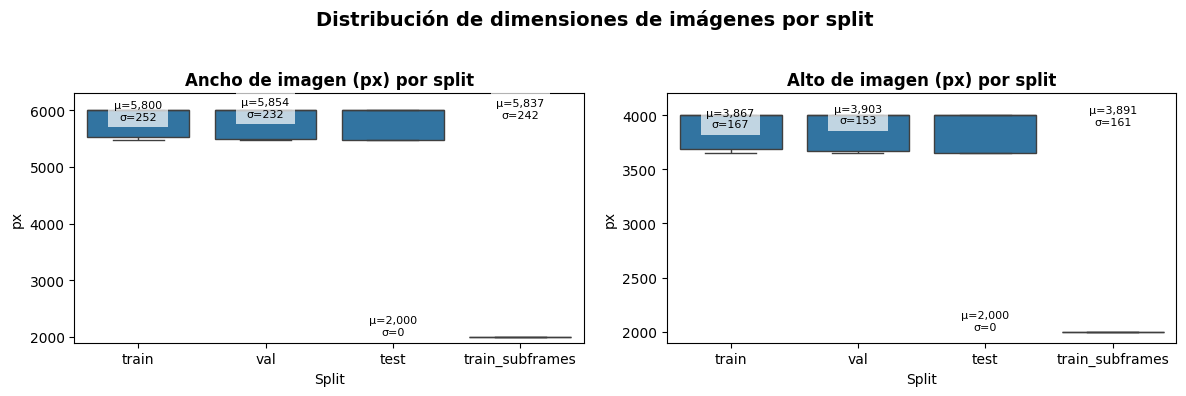

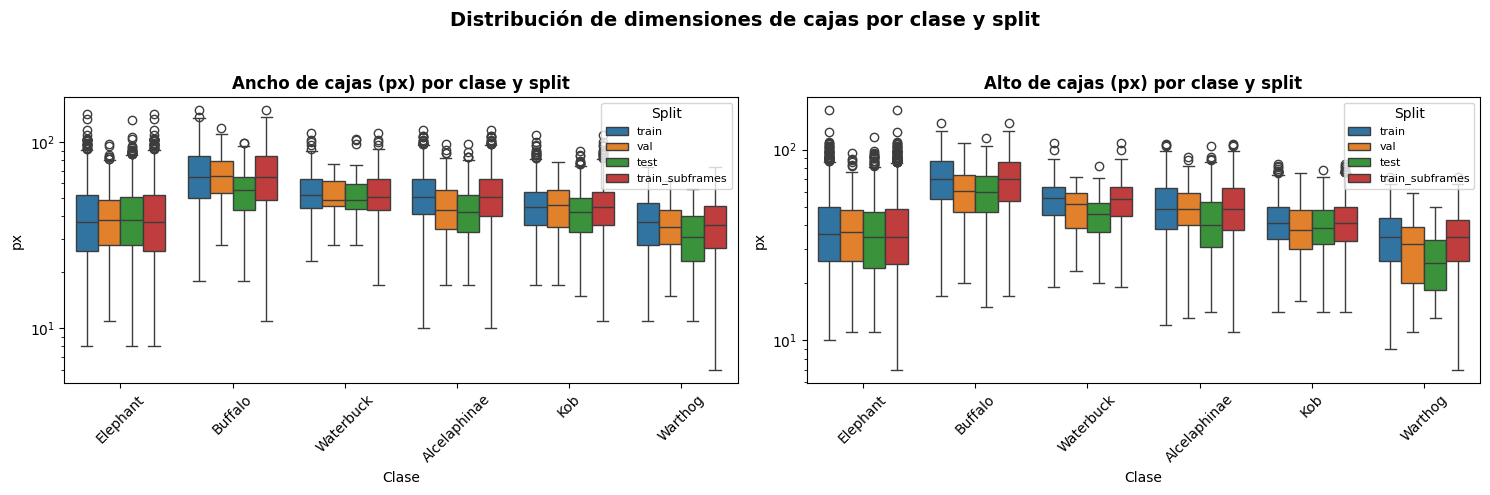

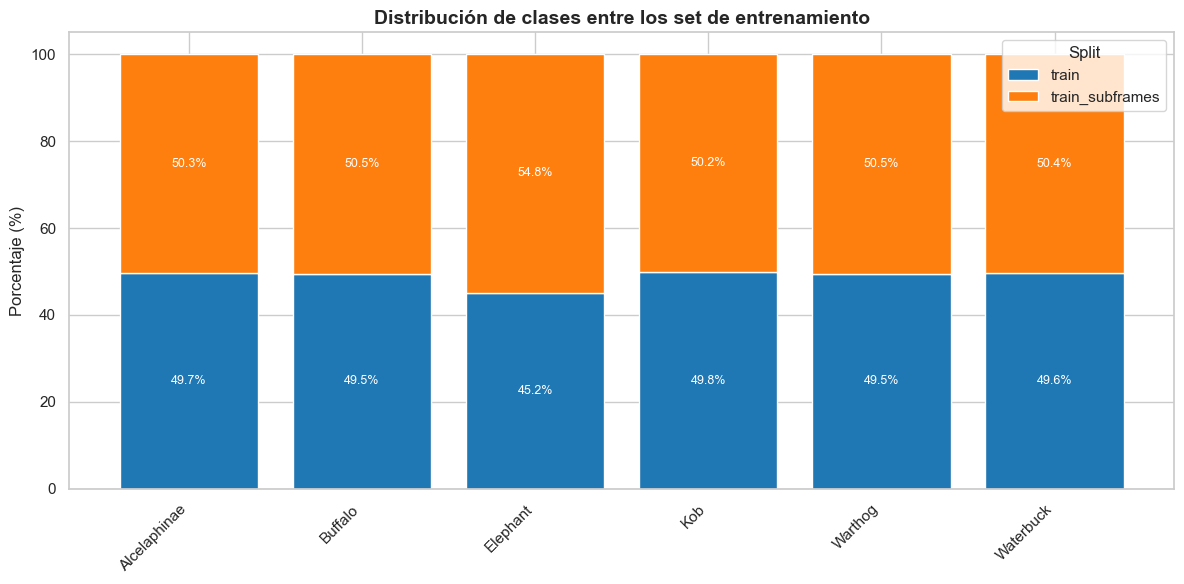

2025-10-22 01:58:42,973 - INFO - Saved stacked class distribution report: C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\reports\train_split_stacked_distribution.csv


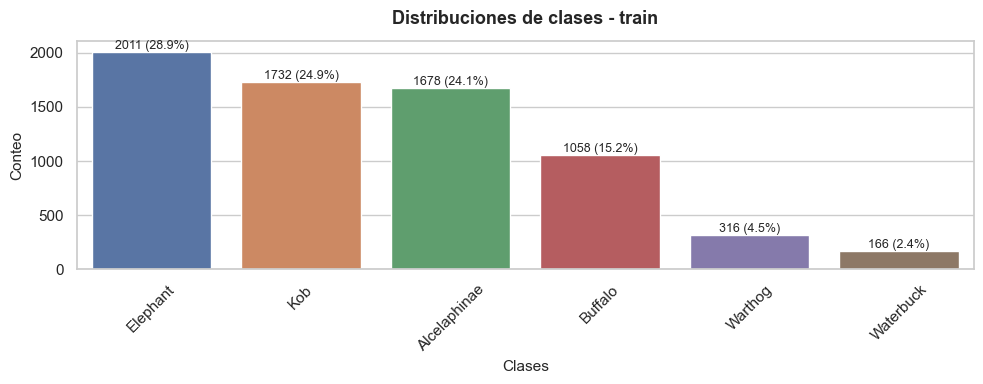

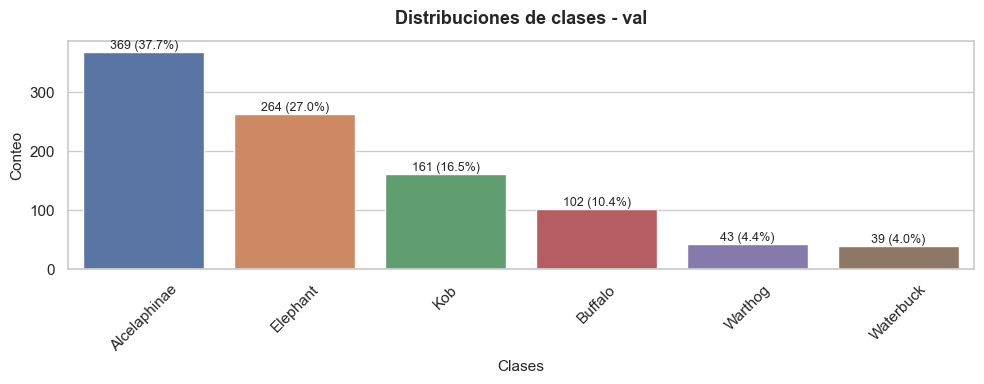

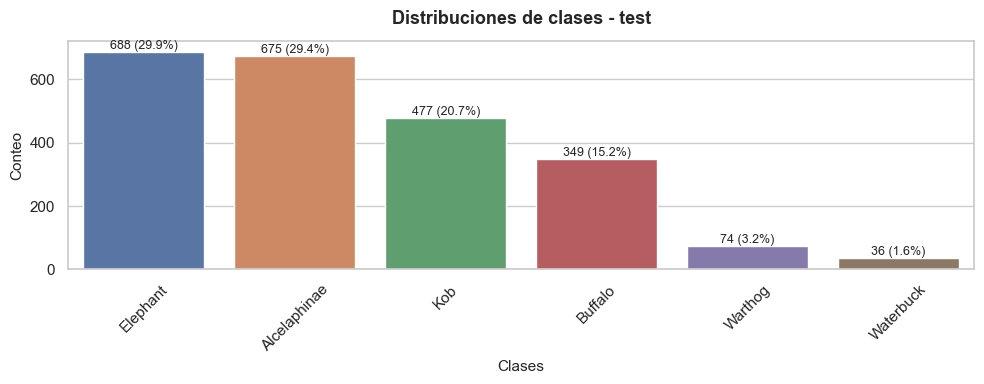

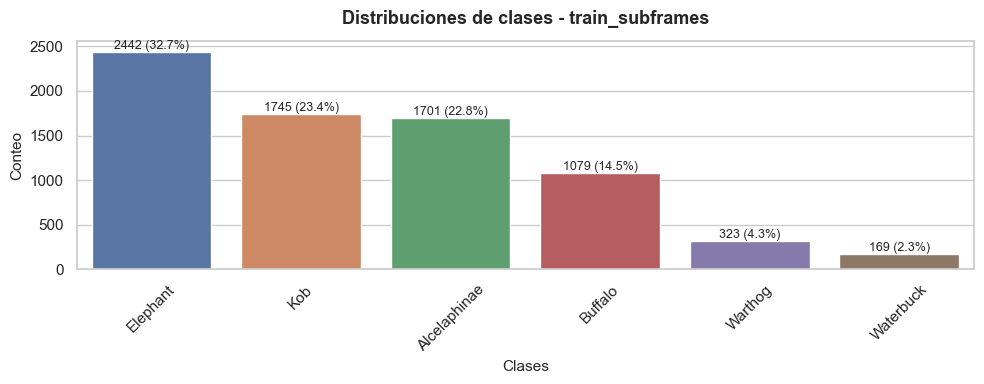

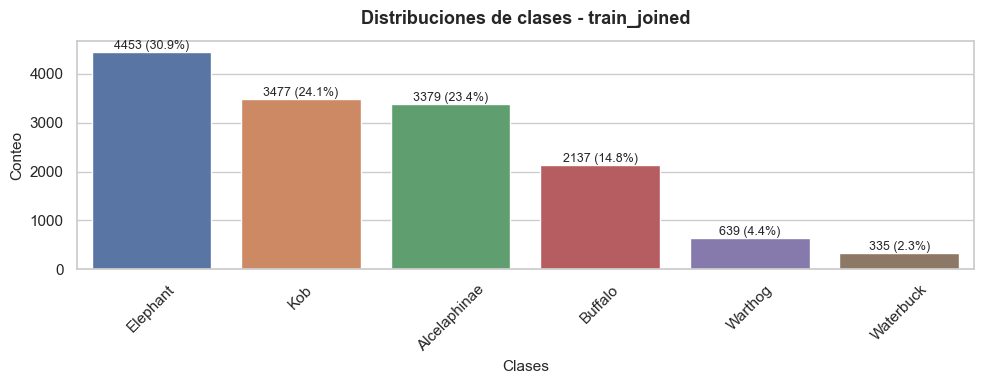

2025-10-22 01:58:43,920 - INFO - Saved global class distribution summary: C:\Users\Jaime\Documents\Projects\animal-count\data\outputs\reports\class_distribution_all_splits.csv


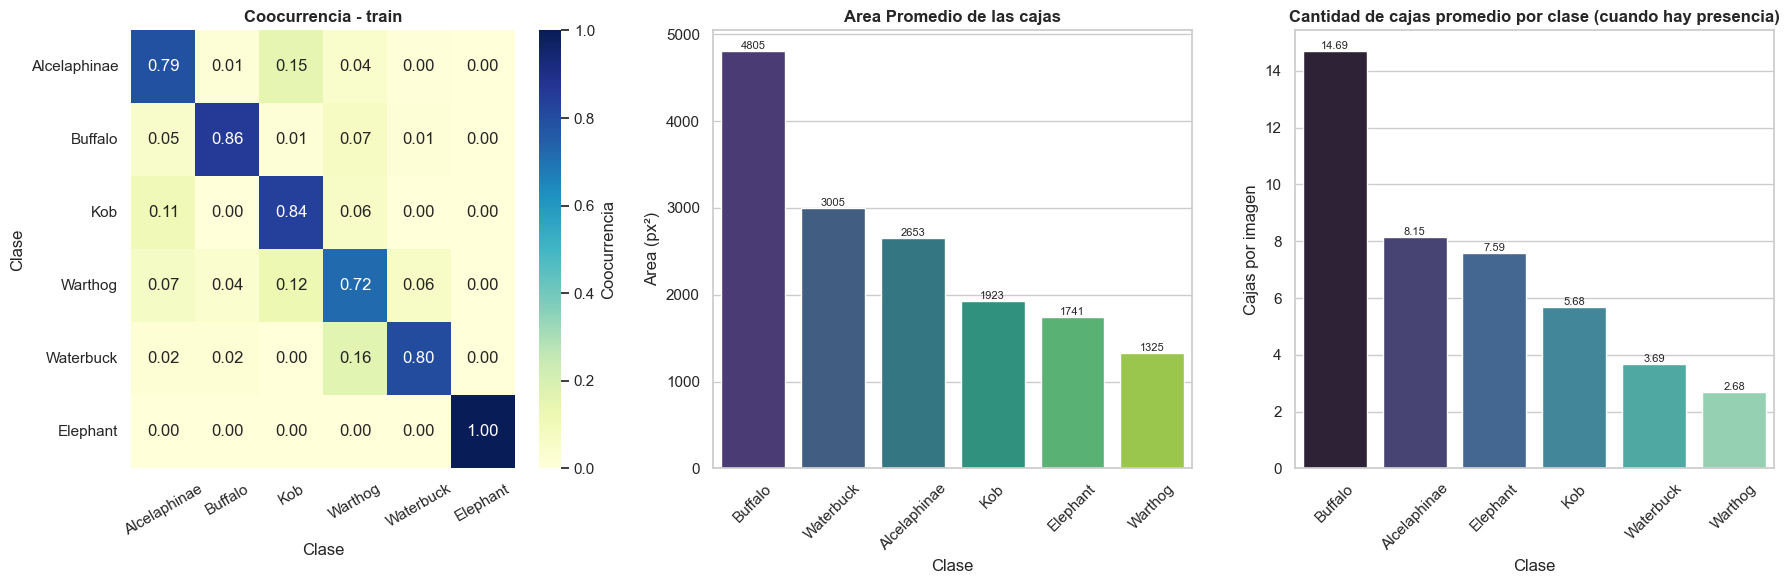

2025-10-22 01:58:44,531 - INFO - [COOC] Saved analysis for split 'train' at cooccurrence_boxsize_boxcount_train.png



Co-occurrence, box size and per-image count analysis completed successfully.
          class  n_images_with_class  total_boxes  mean_boxes_per_image  \
0  Alcelaphinae                  206         1678                  8.15   
1       Buffalo                   72         1058                 14.69   
2           Kob                  305         1732                  5.68   
3       Warthog                  118          316                  2.68   
4     Waterbuck                   45          166                  3.69   

   mean_bbox_area  std_bbox_area  
0         2652.60        1086.44  
1         4805.16        2003.07  
2         1923.06         711.89  
3         1325.02         633.16  
4         3004.66        1106.10  

FINAL PIPELINE SUMMARY
final_status: success
completed_stages: 5
total_stages: 5
stage_timings: {'Stage 1 - Verification': {'status': 'success', 'duration_sec': 499.93}, 'Stage 2 - Validation & Filtering': {'status': 'success', 'duration_sec': 2.84}, 'Stage 3 

<Figure size 640x480 with 0 Axes>

In [2]:
# ==============================================================
#  RUN FULL QUALITY CHECK PIPELINE
# ==============================================================
import os
import yaml

# --------------------------------------------------------------
# Step 1: Load YAML configuration
# --------------------------------------------------------------
CONFIG_PATH = "quality_config.yaml"  # Ruta al archivo YAML de configuración

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

# --------------------------------------------------------------
# Step 2: Initialize the quality checker
# --------------------------------------------------------------
checker = DatasetChecker(
    config_path=CONFIG_PATH,   # ruta del YAML
    num_workers=config.get("num_workers", 8),
    verbose=True
)

# --------------------------------------------------------------
# Step 3: Validate configuration (extra assurance)
# --------------------------------------------------------------
config_validated = checker._validate_config(config)
print("Configuration loaded and validated successfully.")
print(f"Splits: {list(config_validated['splits'].keys())}")
print(f"Classes: {config_validated['classes']}")

# --------------------------------------------------------------
# Step 4: Run the complete dataset pipeline
# --------------------------------------------------------------
summary = checker.run_full_check()

# --------------------------------------------------------------
# Step 5: Additional visual analytics
# --------------------------------------------------------------
checker.plot_dimension_distributions()     # Tamaños de imágenes y cajas
checker.plot_train_splits_stacked()        # Comparativa train vs subframes
checker.plot_class_distributions()

try:
    result = checker.plot_cooccurrence_and_boxsize(split="train", normalize=True)
    print("\nCo-occurrence, box size and per-image count analysis completed successfully.")
    print(result["df_intra"].head())
except Exception as e:
    print(f"[WARN] Co-occurrence analysis skipped due to error: {e}")


# --------------------------------------------------------------
# Step 6: Print summarized results
# --------------------------------------------------------------
print("\n" + "=" * 80)
print("FINAL PIPELINE SUMMARY")
print("=" * 80)
for k, v in summary.items():
    print(f"{k}: {v}")
print("=" * 80)